# Locally Weighted Correlation Coefficient

## 1. Data Preparation

In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np

from mgwr.gwr import GWR, MGWR, GWRResults
from mgwr.sel_bw import Sel_BW
from scipy import stats
from sklearn.preprocessing import StandardScaler


import matplotlib.pyplot as plt
from matplotlib_scalebar.scalebar import ScaleBar

import seaborn as sns
sns.set(color_codes=True)

import warnings
warnings.filterwarnings('ignore')

scaler = StandardScaler()
%matplotlib inline



gsv = pd.read_csv("C:\\Users\\Lenovo\\Documents\\Personal\\Projects\\corrcoef\\data\\gsv_indicators_summarized_county.csv")  # Google streetview Data
zipcode = pd.read_csv('C:\\Users\\Lenovo\\Documents\\Personal\\Projects\\corrcoef\\data\\zip_code_database.csv')
census =     pd.read_csv('C:\\Users\\Lenovo\\Documents\\Personal\\Projects\\corrcoef\\data\\summary_zipcode_oct_1_2020.csv')

df = pd.read_csv('C:\\Users\\Lenovo\\Documents\\Personal\\Projects\\corrcoef\\data\\ACSST1Y2021.S2504-Data.csv')   # ACS Census Data 2021

In [2]:
gsv.head()

,county,prop_green,prop_crosswalk,prop_not_single_family_house,prop_single_lane,prop_triple_lane,prop_visible_wires,prop_sidewalk,prop_dilapidated_building
0,1001,0.969148,0.005288,0.089308,0.677698,0,0.343879,0.085365,0.083976
1,1003,0.947018,0.007764,0.116095,0.677067,0,0.436140,0.108644,0.097183
2,1005,0.978433,0.004444,0.102145,0.665148,0,0.277878,0.043388,0.071833
3,1007,0.992821,0.002094,0.046022,0.732843,0,0.242073,0.035595,0.054354
4,1009,0.972386,0.002662,0.115099,0.674392,0,0.358319,0.032216,0.087506


In [3]:
gsv = gsv.apply(lambda x: x * 100) 
gsv['county'] = gsv.county//100

In [4]:
gsv.head(2)

,county,prop_green,prop_crosswalk,prop_not_single_family_house,prop_single_lane,prop_triple_lane,prop_visible_wires,prop_sidewalk,prop_dilapidated_building
0,1001,96.914770,0.528769,8.930812,67.769762,0,34.387883,8.536476,8.397562
1,1003,94.701791,0.776435,11.609485,67.706725,0,43.614030,10.864435,9.718299


In [5]:
df.head(2)

,Geography,Geographic Area Name,Estimate Occupied housing units Occupied housing units,"Estimate Occupied housing units Occupied housing units UNITS IN STRUCTURE 1, detached","Estimate Occupied housing units Occupied housing units UNITS IN STRUCTURE 1, attached",Estimate Occupied housing units Occupied housing units UNITS IN STRUCTURE 2 apartments,Estimate Occupied housing units Occupied housing units UNITS IN STRUCTURE 3 or 4 apartments,Estimate Occupied housing units Occupied housing units UNITS IN STRUCTURE 5 to 9 apartments,Estimate Occupied housing units Occupied housing units UNITS IN STRUCTURE 10 or more apartments,Margin of Error Occupied housing units Occupied housing units UNITS IN STRUCTURE 10 or more apartments,...,Margin of Error Percent renter-occupied housing units Occupied housing units HOUSE HEATING FUEL Coal or coke,Annotation of Margin of Error Percent renter-occupied housing units Occupied housing units HOUSE HEATING FUEL Coal or coke,Estimate Percent renter-occupied housing units Occupied housing units HOUSE HEATING FUEL All other fuels,Margin of Error Percent renter-occupied housing units Occupied housing units HOUSE HEATING FUEL All other fuels,Annotation of Margin of Error Percent renter-occupied housing units Occupied housing units HOUSE HEATING FUEL All other fuels,Annotation of Estimate Percent renter-occupied housing units Occupied housing units HOUSE HEATING FUEL All other fuels,Estimate Percent renter-occupied housing units Occupied housing units HOUSE HEATING FUEL No fuel used,Margin of Error Percent renter-occupied housing units Occupied housing units HOUSE HEATING FUEL No fuel used,Annotation of Margin of Error Percent renter-occupied housing units Occupied housing units HOUSE HEATING FUEL No fuel used,Annotation of Estimate Percent renter-occupied housing units Occupied housing units HOUSE HEATING FUEL No fuel used
0,0500000US01003,"Baldwin County, Alabama",94105,68415,2332,383,2471,2454,7740,2545,...,N,N,N,N,N,N,N,N,N,N
1,0500000US01015,"Calhoun County, Alabama",44631,33266,342,559,1158,1632,1863,735,...,N,N,N,N,N,N,N,N,N,N


#### Selecting columns of interest from ACS census {`apartments` and `county`}

In [6]:
not_residential = df[['Geography','Estimate Percent occupied housing units Occupied housing units UNITS IN STRUCTURE 10 or more apartments']]

In [7]:
not_residential.rename(columns={'Estimate Percent occupied housing units Occupied housing units UNITS IN STRUCTURE 10 or more apartments':'apartments', 'Geography':'County'}, inplace=True)

In [8]:
not_residential['County'] = not_residential['County'].str.split('S', expand=True)[1]
not_residential['County'] = not_residential['County'].astype(int)

In [9]:
# Merge ACS census data with GSV indicators

merged = gsv.merge(not_residential, left_on='county', right_on='County', how='inner')

In [10]:
not_residential.head()

,County,apartments
0,1003,8.2
1,1015,4.2
2,1043,1.6
3,1049,1.8
4,1051,4.1


In [11]:
merged.head()

,county,prop_green,prop_crosswalk,prop_not_single_family_house,prop_single_lane,prop_triple_lane,prop_visible_wires,prop_sidewalk,prop_dilapidated_building,County,apartments
0,1003,94.701791,0.776435,11.609485,67.706725,0,43.614030,10.864435,9.718299,1003,8.2
1,1015,96.123673,0.675662,11.003635,74.779742,0,41.725710,8.514571,10.451194,1015,4.2
2,1043,96.653409,0.444817,9.852687,71.849652,0,41.757810,5.553666,8.159768,1043,1.6
3,1049,95.998921,0.194564,10.724124,82.105912,0,41.297606,3.031150,8.950897,1049,1.8
4,1051,97.244733,0.562196,11.980011,60.914708,0,35.607442,4.971975,9.486426,1051,4.1


#### Convert county FIPS to point {lat, lon}

In [12]:
import geopandas as gpd
from geopandas import GeoDataFrame

counties = gpd.read_file('https://cdn.jsdelivr.net/npm/us-atlas@3/counties-10m.json')\
                                                                            .sort_values(by='id').reset_index(drop=True)

empty = counties['geometry'].is_empty
counties_non_empty = counties[~empty]
# counties.head()
len(counties)

3231

In [13]:
counties_non_empty['lon'] = counties_non_empty['geometry'].centroid.x
counties_non_empty['lat'] = counties_non_empty['geometry'].centroid.y
counties_non_empty['id'] = counties_non_empty['id'].astype('int')
counties_non_empty.head()

,id,name,geometry,lon,lat
0,1001,Autauga,"POLYGON ((-86.91684 32.66395, -86.71225 32.661...",-86.641721,32.535922
1,1003,Baldwin,"POLYGON ((-88.00799 30.68468, -88.02593 30.753...",-87.723428,30.727208
2,1005,Barbour,"POLYGON ((-85.65700 31.88049, -85.64982 31.911...",-85.392290,31.869504
3,1007,Bibb,"POLYGON ((-87.42293 33.00328, -87.31884 33.005...",-87.128405,32.997662
4,1009,Blount,"POLYGON ((-86.96350 33.85804, -86.92043 33.873...",-86.566051,33.981451


In [14]:
len(counties_non_empty)

3230

#### Merge all the dataframes to get a single df with all relevant features

In [15]:
data = merged.merge(counties_non_empty, left_on='county', right_on='id', how='inner')

In [16]:
len(data)

809

In [17]:
data.drop(['County', 'id', 'name'], axis=1, inplace=True)  # drop some irrelevant columns

In [18]:
data['apartments'] = data['apartments'].apply(lambda x: pd.to_numeric(x, errors='coerce'))
data = data.dropna()

In [19]:
data.head()

,county,prop_green,prop_crosswalk,prop_not_single_family_house,prop_single_lane,prop_triple_lane,prop_visible_wires,prop_sidewalk,prop_dilapidated_building,apartments,geometry,lon,lat
0,1003,94.701791,0.776435,11.609485,67.706725,0,43.614030,10.864435,9.718299,8.2,"POLYGON ((-88.00799 30.68468, -88.02593 30.753...",-87.723428,30.727208
1,1015,96.123673,0.675662,11.003635,74.779742,0,41.725710,8.514571,10.451194,4.2,"POLYGON ((-86.06618 33.84258, -85.99439 33.864...",-85.825913,33.771158
2,1043,96.653409,0.444817,9.852687,71.849652,0,41.757810,5.553666,8.159768,1.6,"POLYGON ((-87.15015 33.99291, -87.11066 33.992...",-86.867200,34.132108
3,1049,95.998921,0.194564,10.724124,82.105912,0,41.297606,3.031150,8.950897,1.8,"POLYGON ((-86.05900 34.47571, -86.00516 34.480...",-85.802657,34.461177
4,1051,97.244733,0.562196,11.980011,60.914708,0,35.607442,4.971975,9.486426,4.1,"POLYGON ((-86.37486 32.75329, -86.00875 32.755...",-86.150142,32.597219


## 2. Modelling

#### Prepare data for GWR and LWCC

In [20]:
g_y = data['prop_crosswalk'].values.reshape((-1,1))
g_X = data[['apartments']].values

u = data['lon']
v = data['lat']

g_coords = list(zip(u,v))

<AxesSubplot:>

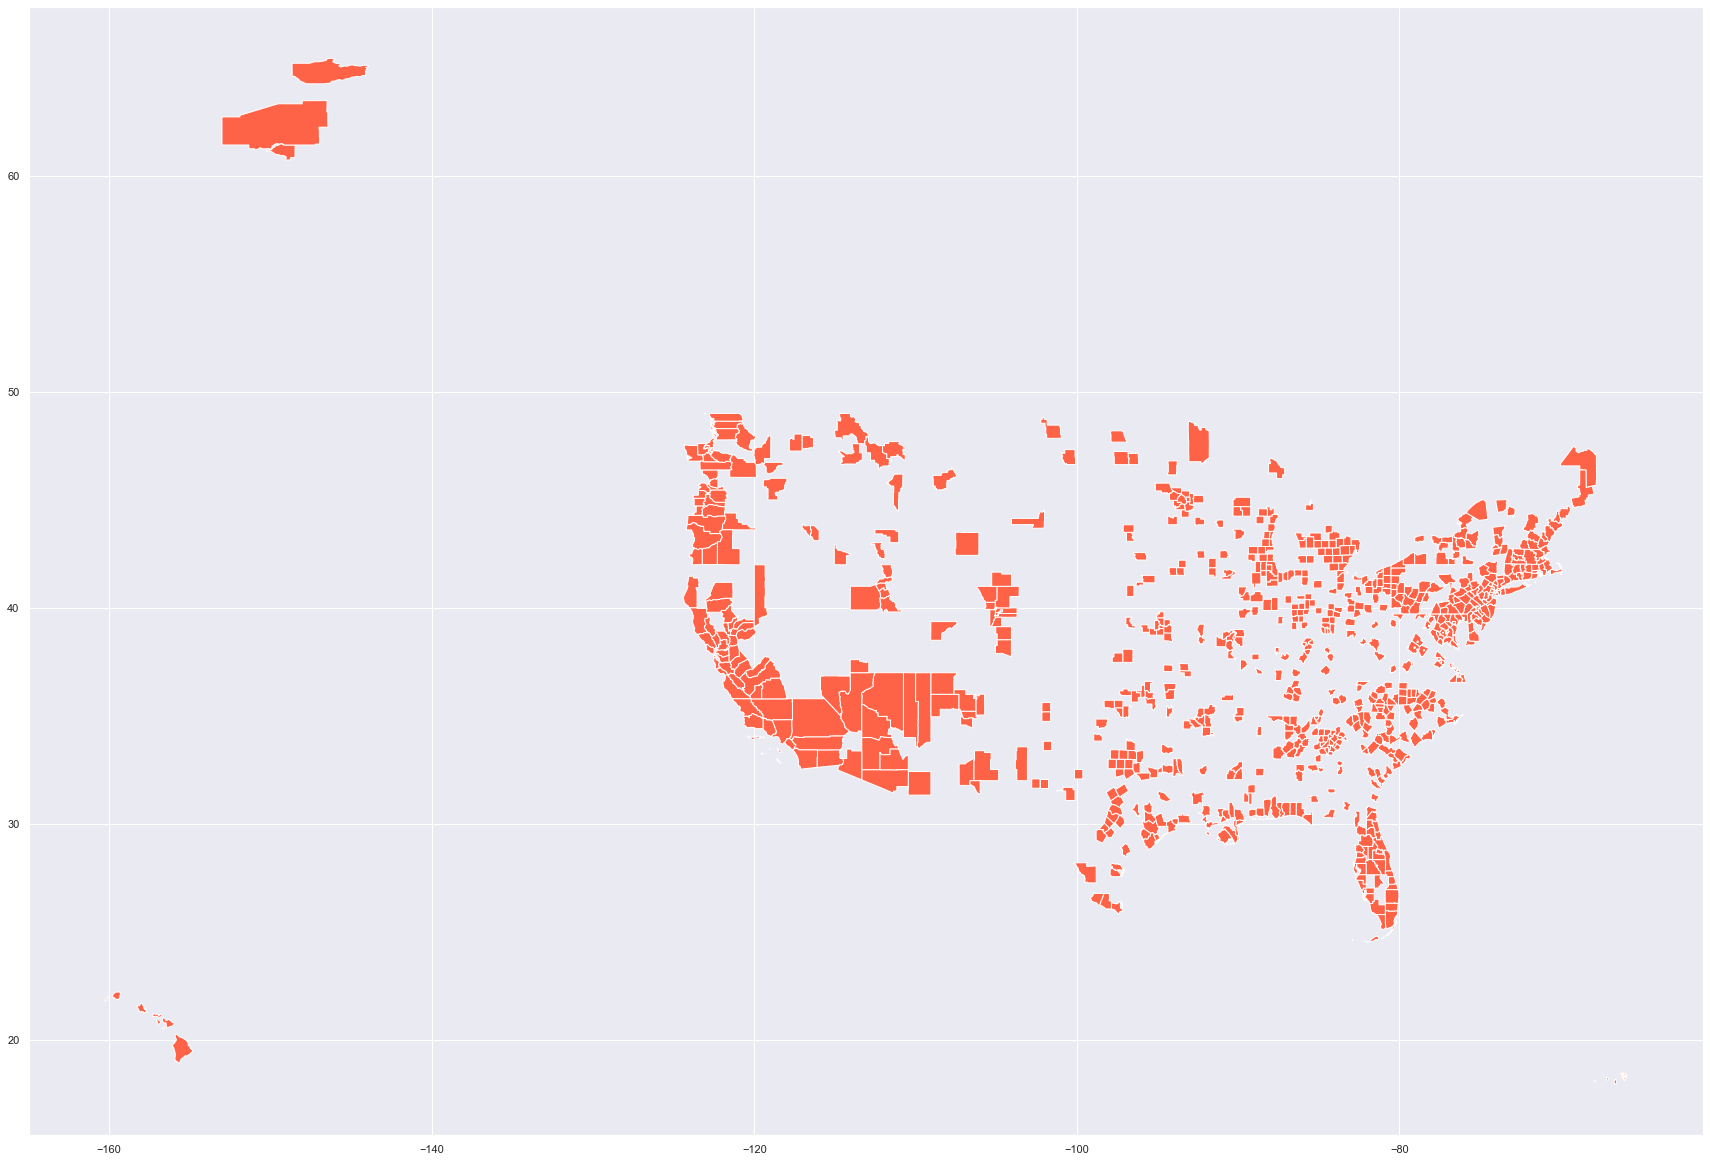

In [21]:
gdf = GeoDataFrame(data, crs="EPSG:4326")  # change the EPSG, see whether the result changes

# # gdf.plot(figsize=(50, 50))

fig, ax = plt.subplots(figsize=(30,30))
gdf.plot(ax=ax, color='tomato')
# minx, miny, maxx, maxy = gdf.total_bounds
# ax.set_xlim(minx, maxx)
# ax.set_ylim(miny, maxy)

#### Calculate LCC using the old algo `{standardize ---> weight}`

In [22]:
gwr_selector_o = Sel_BW(g_coords, g_y, g_X)
gwr_bw_o = gwr_selector_o.search()
print(gwr_bw_o)
gwr_results_o = GWR(g_coords, g_y, g_X, gwr_bw_o, constant=True, lwcc=False).fit()
gwr_results_o.summary()

64.0
Model type                                                         Gaussian
Number of observations:                                                 807
Number of covariates:                                                     2

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                            365.955
Log-likelihood:                                                    -825.990
AIC:                                                               1655.981
AICc:                                                              1658.011
BIC:                                                              -5022.170
R2:                                                                   0.547
Adj. R2:                                                              0.546

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- -

#### GW - Correlation Coefficient -- From the [Book](https://www.academia.edu/33626785/Geographically_Weighted_Regression_The_Analysis_of_Spatially_Varying_Relationships_Wiley_2002)


$$
   \frac{(x_j - \overline x_i)(y_j - \overline y_i) w_ij}{w_ij\sqrt (x_j - \overline x_i)^2 . \sqrt (y_j - \overline y_i)^2 }\
$$

From Page 162-163 of [GWR - The analysis of spatially varying relationships](https://www.academia.edu/33626785/Geographically_Weighted_Regression_The_Analysis_of_Spatially_Varying_Relationships_Wiley_2002)


In [142]:
# Alternative LWCC Calculation

for i in range(len(g_X)):
    wi = gwr_results_o.model._build_wi(i, gwr_bw_o).reshape(-1,1)
    x = g_X
    xi_mean = (x*wi).mean()
    y = g_y
    yi_mean = (y*wi).mean()
    x_diff = [var-xi_mean for var in x]
    y_diff = [var-yi_mean for var in y]
    xyw = ([a*b*c for a,b,c in list(zip(x_diff,y_diff, wi))])
    
    x_sq = [a*a for a in x_diff]
    y_sq = [b*b for b in y_diff]
    denom = np.sqrt(np.array(x_sq) * np.array(y_sq))
    
    r = xyw / denom
    
r.mean()

0.012759687283259631


This result I got implementing the formula in the cells above was questionable, so I went ahead to extract the local collinearity method from the GWR codebase, pulled out the relevant function code and implemented it for two variables. `X` and `y` As such below

In [56]:
"""Local collinearity formula implementation. Extracted from MGWR codebase, line 1092, gwr.py, __author__ = Taylor Oshan"""

# x_scaled = scaler.fit_transform(x)
# y_scaled = scaler.fit_transform(y)


x_ = np.hstack((x, y))

def corr(cov):
    invsd = np.diag(1 / np.sqrt(np.diag(cov)))
    cors = np.dot(np.dot(invsd, cov), invsd)
    return cors

corr_mat = np.ndarray(shape=(807, 1))
sw = np.sum(wi)
wi = wi/sw

for i in range(len(x_)):
    wi_ = gwr_results_o.model._build_wi(i, gwr_bw_o)
    corr_mat[i] = corr(np.cov(x_[:, 0], x_[:, 1], aweights=wi_))[0][1]


In [57]:
corr_mat.mean()

0.7119445670511535

## 3. Cartography

#### Visualization of Textbook implemetation of LWCC

In [31]:
data['textbook_calc'] = r

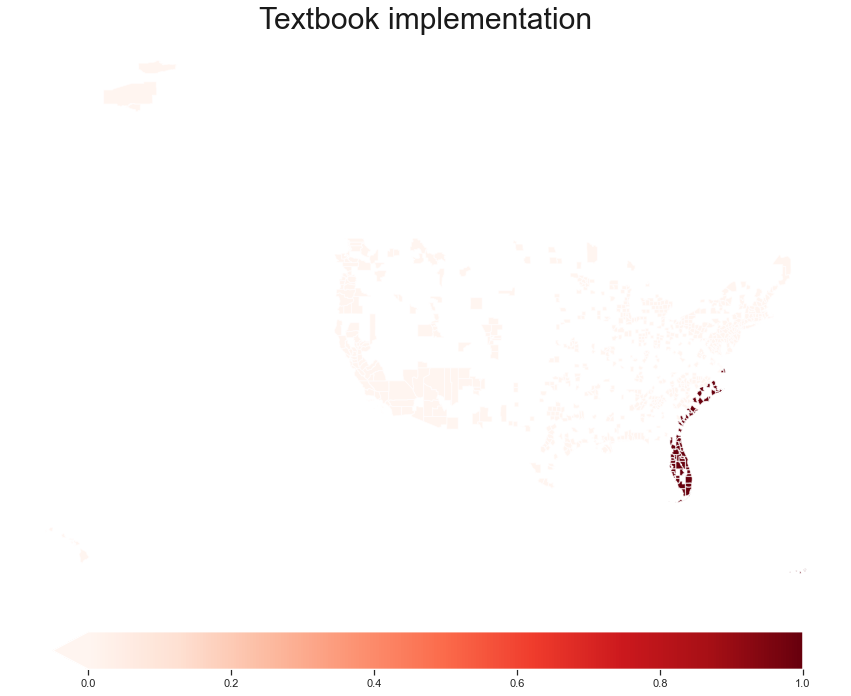

In [32]:
figsize=(14,10)
fig, ax = plt.subplots(1, figsize=(15, 15))

gdf.plot(column='textbook_calc', ax=ax, cmap='Reds', figsize=figsize, linewidth=0.5,)

ax.axis("off")

scatter = ax.collections[-1]
plt.colorbar(scatter, ax=ax, extend='min', orientation='horizontal', fraction=0.046, pad=0.04)
gdf.boundary.plot(ax=ax, color='white',alpha=0.2)


plt.title("Textbook implementation", fontsize='30', color='k')


plt.savefig("./images/textbook")

The output visualization above is why I asserted that this method was questionable. 

#### Visualization of GWR Local collinearity implementation 

In [33]:
data['gwr_calc'] = corr_mat

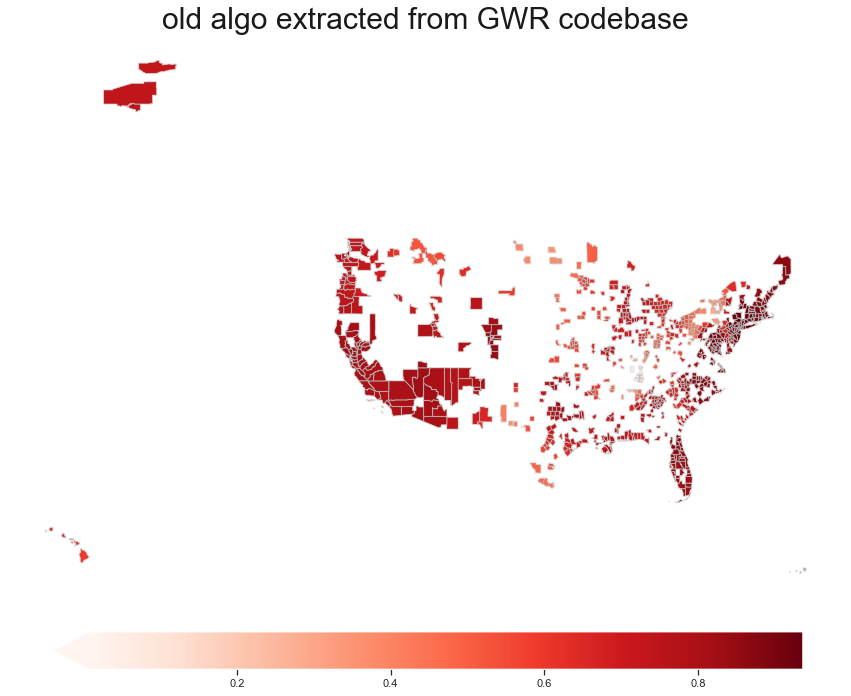

In [34]:
figsize=(14,10)
fig, ax = plt.subplots(1, figsize=(15, 15))

gdf.plot(column='gwr_calc', ax=ax, cmap='Reds', figsize=figsize, linewidth=0.5,)

ax.axis("off")

scatter = ax.collections[-1]
plt.colorbar(scatter, ax=ax, extend='min', orientation='horizontal', fraction=0.046, pad=0.04)
gdf.boundary.plot(ax=ax, color='gray',alpha=0.2)


plt.title("old algo extracted from GWR codebase", fontsize='30', color='k')


plt.savefig("./images/gwr_calc")

#### Calculate LCC using the new algo `{weight ---> standardize}`

In [25]:
gwr_selector_n = Sel_BW(g_coords, g_y, g_X)
gwr_bw_n = gwr_selector_n.search()
print(gwr_bw_n)
gwr_results_n = GWR(g_coords, g_y, g_X, gwr_bw_n, constant=False, lwcc=True).fit()
gwr_results_n.summary()

64.0
Model type                                                         Gaussian
Number of observations:                                                 807
Number of covariates:                                                     1

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                            973.639
Log-likelihood:                                                   -1220.827
AIC:                                                               2443.655
AICc:                                                              2445.670
BIC:                                                              -4421.179
R2:                                                                   0.536
Adj. R2:                                                              0.536

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- -

In [26]:
data['new_algo_params'] = gwr_results_n.params

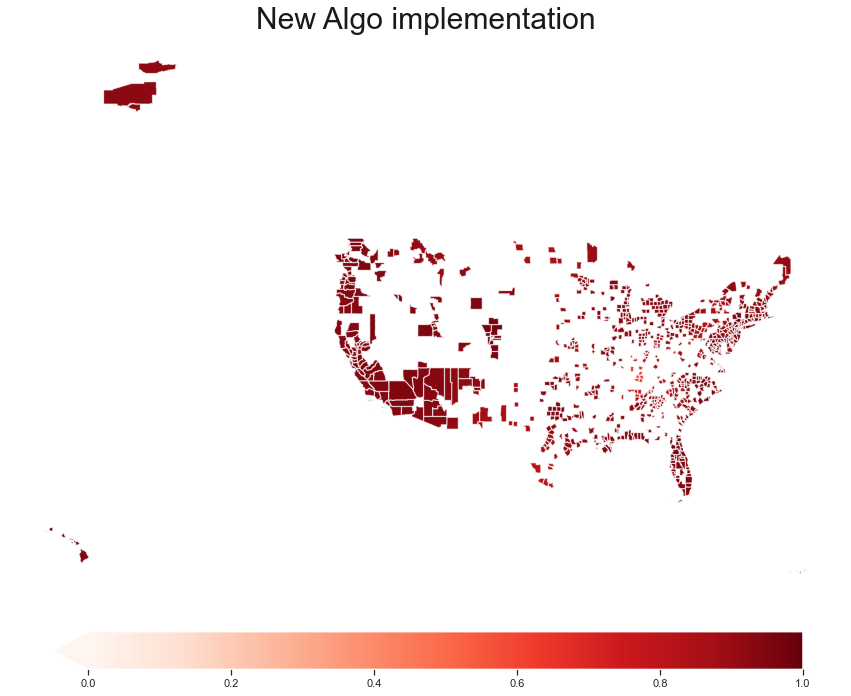

In [27]:
figsize=(14,10)
colors = 6
fig, ax = plt.subplots(1, figsize=(15, 15))

gdf.plot(column='new_algo_params', ax=ax, cmap='Reds', figsize=figsize, linewidth=0.5, vmin=0, vmax=1)

ax.axis("off")

scatter = ax.collections[-1]
plt.colorbar(scatter, ax=ax, extend='min', orientation='horizontal', fraction=0.046, pad=0.04)
gdf.boundary.plot(ax=ax,color='white',alpha=0.2)


plt.title("New Algo implementation", fontsize='30', color='k')


plt.savefig("./images/new_algo")

#### Locally weightedPeason's r Independently calculated

In [78]:
corr = []

for i in range(len(g_X)):
    wi = gwr_results_o.model._build_wi(i, gwr_bw_o).reshape(-1,1)
    xw = g_X*wi
    yw = g_y*wi
    corr_coef, _ = stats.pearsonr(xw.flatten(), yw.flatten())
    corr.append(corr_coef)

np.array(corr).mean()

0.9170516323203886

#### Global correlation coefficient

In [136]:
corr_g = []
corr_coef, _ = stats.pearsonr(g_X.flatten(), g_y.flatten())
corr_g.append(corr_coef)
corr_g

[0.7392725407250684]

#### Global Regression

In [30]:
# import statsmodels.api as sm
# from sklearn.preprocessing import StandardScaler

# scaler = StandardScaler()

# # xi =  g_X - g_X.mean(axis=0) / g_X.std(axis=0)
# # yi =  g_y - g_y.mean(axis=0) / g_y.std(axis=0)


# xi = scaler.fit_transform(g_X)
# yi = scaler.fit_transform(g_y)

# sm_results = sm.OLS(yi, xi).fit()

# sm_results.params

#### [Old Algo] Keep a random variable as the y for local_collinearity() 